# Perfilado de Empleados con Clustering (Employee Profiling with Clustering)

Este notebook analiza datos de empleados para identificar perfiles mediante un modelo de K-Means, utilizando variables ampliadas y reducción de dimensionalidad con PCA. El análisis incluye:
- Carga de datos desde SQL Server
- Preprocesamiento de datos con escalamiento y PCA
- Determinación del número óptimo de clusters con el método del codo
- Entrenamiento del modelo K-Means
- Evaluación de resultados con métrica de calidad
- Visualización de clusters y centroides
- Almacenamiento de predicciones y métricas en SQL Server

## 1. Importación de Bibliotecas

Importamos las bibliotecas necesarias para el análisis, clustering y PCA.

In [1]:
import pandas as pd
import snowflake.connector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import logging
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Configurar advertencias y logging
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('customer_segmentation.log')
    ]
)


# Configuración de logging
logging.basicConfig(level=logging.INFO)

c:\Users\joey_\AppData\Local\Programs\Python\Python310\lib\site-packages\snowflake\connector\options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (19.0.1), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(


## 2. Conexión a Base de Datos y Consulta

Configuramos la conexión a SQL Server y ejecutamos la consulta para obtener los datos de empleados.

In [5]:
def get_snowflake_connection():
    try:
        conn = snowflake.connector.connect(
            user='ringoquimicodev',  
            password='Ch3cooch2ch2ch3',  
            account='RSB72105', 
            warehouse='COMPUTE_WH', 
            database='BEBIDAS_PROJECT',
            schema='BEBIDAS_ANALYTICS'
        )
        logging.info("Conexión a Snowflake exitosa")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión a Snowflake: {e}")
        raise


def load_snowflake_views():
    conn = get_snowflake_connection()
    try:
        df = pd.read_sql("SELECT * FROM VW_CLIENTES_PERFIL", conn)
        return df
    finally:
        conn.close()

# Load data
df = load_snowflake_views()

logging.info(f"Datos cargados: {len(df)} registros")
df.head(10)

2025-06-29 16:55:54,980 - INFO - Snowflake Connector for Python Version: 3.15.0, Python Version: 3.10.11, Platform: Windows-10-10.0.19045-SP0
2025-06-29 16:55:54,992 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-29 16:55:55,747 - INFO - Conexión a Snowflake exitosa
2025-06-29 16:55:58,041 - INFO - Datos cargados: 2000 registros


,CLIENTE_ID,CIUDAD,TIEMPO_CLIENTE_MESES,DIAS_ULTIMA_COMPRA,TICKETS_TOTALES,PROMEDIO_TICKETS_POR_MES,CANAL_MAS_FRECUENTE,PRODUCTO_MAS_FRECUENTE,CATEGORIA_MAS_FRECUENTE,TOTAL_CANTIDADES,PROMEDIO_CANTIDADES_POR_MES,PROMEDIO_DESCUENTOS_TOTALES,TOTAL_FACTURADO,TOTAL_FACTURADO_PROMEDIO_POR_MES,PROMEDIO_MARGEN_TOTAL,NUMERO_CANALES_DISTINTOS,NUMERO_PRODUCTOS_DISTINTOS,NUMERO_CATEGORIAS_DISTINTAS,FRECUENCIA_COMPRA_DIAS,PORCENTAJE_TRANSACCIONES_CON_DESCUENTO
0,1,Barranquilla,29,32,36,1.565217,Tienda de Conveniencia,Jugo Lima 2000mL x 12uds,Jugo,2709,117.782609,8.611111,1.774627e+08,7.715771e+06,47.763889,5,14,5,24.800000,52.7778
1,2,Villavicencio,29,21,41,1.782609,Supermercado,Jugo Lima 2000mL x 12uds,Jugo,2808,122.086957,8.731707,2.245144e+08,9.761496e+06,48.004878,5,15,5,20.725000,53.6585
2,3,Cúcuta,29,18,37,1.761905,Hipermercado,Agua Sin Gas 1L x 1uds,Agua,2252,107.238095,6.783784,1.515154e+08,7.215018e+06,50.359459,5,15,5,23.638889,43.2432
3,4,Barranquilla,29,16,37,1.761905,Hipermercado,Jugo Manzana 2000mL x 24uds,Jugo,2312,110.095238,9.027027,1.746012e+08,8.314342e+06,47.256757,5,15,5,23.361111,54.0541
4,5,Ibagué,29,18,45,1.875000,E-commerce,Agua con Gas 500mL x 6uds,Agua,3227,134.458333,12.488889,1.739350e+08,7.247291e+06,47.506667,5,13,5,19.295455,64.4444
5,6,Tunja,29,21,46,1.916667,Vending Machine,Power Up 250mL x 6uds,Agua,3019,125.791667,7.000000,1.511105e+08,6.296272e+06,51.397826,5,15,5,17.955556,32.6087
6,7,Cartagena,29,29,37,1.761905,E-commerce,Jugo Manzana 2000mL x 24uds,Agua,2676,127.428571,8.810811,2.346815e+08,1.117531e+07,49.886486,5,13,5,23.527778,45.9459
7,8,Bogotá,29,14,39,1.695652,Vending Machine,Jugo Manzana 2000mL x 24uds,Agua,2523,109.695652,6.435897,1.599466e+08,6.954199e+06,52.241026,5,13,5,22.421053,38.4615
8,9,Cali,29,18,40,1.818182,Tienda de Conveniencia,Agua Sin Gas 1L x 1uds,Agua,2717,123.500000,9.475000,1.568787e+08,7.130850e+06,50.347500,5,13,5,22.333333,55.0000
9,10,Cúcuta,29,15,42,1.826087,Vending Machine,Agua Sin Gas 5L x 12uds,Agua,3053,132.739130,7.357143,2.240979e+08,9.743386e+06,51.371429,5,15,5,19.975610,47.6190


In [7]:
df.columns

Index(['CLIENTE_ID', 'CIUDAD', 'TIEMPO_CLIENTE_MESES', 'DIAS_ULTIMA_COMPRA',
       'TICKETS_TOTALES', 'PROMEDIO_TICKETS_POR_MES', 'CANAL_MAS_FRECUENTE',
       'PRODUCTO_MAS_FRECUENTE', 'CATEGORIA_MAS_FRECUENTE', 'TOTAL_CANTIDADES',
       'PROMEDIO_CANTIDADES_POR_MES', 'PROMEDIO_DESCUENTOS_TOTALES',
       'TOTAL_FACTURADO', 'TOTAL_FACTURADO_PROMEDIO_POR_MES',
       'PROMEDIO_MARGEN_TOTAL', 'NUMERO_CANALES_DISTINTOS',
       'NUMERO_PRODUCTOS_DISTINTOS', 'NUMERO_CATEGORIAS_DISTINTAS',
       'FRECUENCIA_COMPRA_DIAS', 'PORCENTAJE_TRANSACCIONES_CON_DESCUENTO'],
      dtype='object')

## 3. Preprocesamiento de Datos

Realizamos el preprocesamiento, escalamiento y reducción de dimensionalidad con PCA.

Columnas disponibles en df: ['CLIENTE_ID', 'CIUDAD', 'TIEMPO_CLIENTE_MESES', 'DIAS_ULTIMA_COMPRA', 'TICKETS_TOTALES', 'PROMEDIO_TICKETS_POR_MES', 'CANAL_MAS_FRECUENTE', 'PRODUCTO_MAS_FRECUENTE', 'CATEGORIA_MAS_FRECUENTE', 'TOTAL_CANTIDADES', 'PROMEDIO_CANTIDADES_POR_MES', 'PROMEDIO_DESCUENTOS_TOTALES', 'TOTAL_FACTURADO', 'TOTAL_FACTURADO_PROMEDIO_POR_MES', 'PROMEDIO_MARGEN_TOTAL', 'NUMERO_CANALES_DISTINTOS', 'NUMERO_PRODUCTOS_DISTINTOS', 'NUMERO_CATEGORIAS_DISTINTAS', 'FRECUENCIA_COMPRA_DIAS', 'PORCENTAJE_TRANSACCIONES_CON_DESCUENTO']
Columnas categóricas disponibles para codificación: ['CIUDAD', 'CANAL_MAS_FRECUENTE', 'PRODUCTO_MAS_FRECUENTE']
Variables seleccionadas para el modelo:
- TIEMPO_CLIENTE_MESES
- DIAS_ULTIMA_COMPRA
- TICKETS_TOTALES
- PROMEDIO_TICKETS_POR_MES
- TOTAL_CANTIDADES
- PROMEDIO_CANTIDADES_POR_MES
- PROMEDIO_DESCUENTOS_TOTALES
- TOTAL_FACTURADO
- TOTAL_FACTURADO_PROMEDIO_POR_MES
- PROMEDIO_MARGEN_TOTAL
- NUMERO_CANALES_DISTINTOS
- NUMERO_PRODUCTOS_DISTINTOS
- NUME

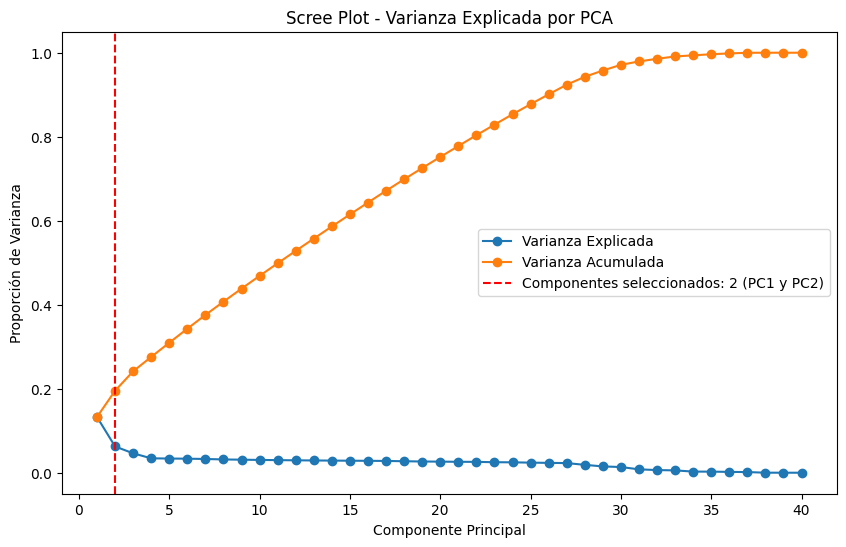

2025-06-29 17:02:01,447 - INFO - Datos preprocesados, escalados y transformados con PCA. Componentes seleccionados: 2 (PC1 y PC2)



Contribución de las variables a PC1 y PC2 (Loadings):
                                                              PC1           PC2
TIEMPO_CLIENTE_MESES                                -2.000900e-02 -2.732199e-02
DIAS_ULTIMA_COMPRA                                  -3.992782e-02  6.430498e-02
TICKETS_TOTALES                                      8.952527e-01  9.064445e-04
PROMEDIO_TICKETS_POR_MES                             8.199627e-01 -2.475571e-02
TOTAL_CANTIDADES                                     9.158557e-01 -3.086613e-03
PROMEDIO_CANTIDADES_POR_MES                          8.190981e-01 -2.535034e-02
PROMEDIO_DESCUENTOS_TOTALES                         -6.444691e-02  9.109872e-01
TOTAL_FACTURADO                                      7.894120e-01  6.365114e-02
TOTAL_FACTURADO_PROMEDIO_POR_MES                     6.611978e-01  5.631069e-02
PROMEDIO_MARGEN_TOTAL                               -6.774819e-03 -8.405247e-01
NUMERO_CANALES_DISTINTOS                            -1.505572e-23

In [8]:

# Depuración: Verificar columnas disponibles en el DataFrame
print("Columnas disponibles en df:", df.columns.tolist())

# Definir columnas categóricas esperadas
expected_categorical_columns = ['CIUDAD', 'CANAL_MAS_FRECUENTE', 'PRODUCTO_MAS_FRECUENTE', 'CATEGORÍA_MAS_FRECUENTE']

# Filtrar solo las columnas categóricas que existen en el DataFrame
available_categorical_columns = [col for col in expected_categorical_columns if col in df.columns]
print("Columnas categóricas disponibles para codificación:", available_categorical_columns)

# Codificación de variables categóricas solo para las columnas disponibles
if available_categorical_columns:
    df = pd.get_dummies(df, columns=available_categorical_columns, drop_first=True)
else:
    print("No se encontraron columnas categóricas para codificar. Revisar la consulta SQL.")

# Selección de características para clustering
features = ['TIEMPO_CLIENTE_MESES', 'DIAS_ULTIMA_COMPRA',
       'TICKETS_TOTALES', 'PROMEDIO_TICKETS_POR_MES', 'TOTAL_CANTIDADES',
       'PROMEDIO_CANTIDADES_POR_MES', 'PROMEDIO_DESCUENTOS_TOTALES',
       'TOTAL_FACTURADO', 'TOTAL_FACTURADO_PROMEDIO_POR_MES',
       'PROMEDIO_MARGEN_TOTAL', 'NUMERO_CANALES_DISTINTOS',
       'NUMERO_PRODUCTOS_DISTINTOS', 'NUMERO_CATEGORIAS_DISTINTAS',
       'FRECUENCIA_COMPRA_DIAS', 'PORCENTAJE_TRANSACCIONES_CON_DESCUENTO'] + \
           [col for col in df.columns if any(prefix in col for prefix in ['CIUDAD_', 'CANAL_MAS_FRECUENTE_', 'PRODUCTO_MAS_FRECUENTE_', 'CATEGORÍA_MAS_FRECUENTE_'])]

# Listar las variables seleccionadas para el modelo
print("Variables seleccionadas para el modelo:")
for feature in features:
    print(f"- {feature}")

X = df[features]

# Estandarización de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Seleccionar solo las dos primeras componentes principales (PC1 y PC2)
n_components = 2
X_pca = X_pca[:, :n_components]

# Mostrar resultados de PCA: Varianza explicada
pca_results = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Varianza Explicada': pca.explained_variance_ratio_,
    'Varianza Acumulada': np.cumsum(pca.explained_variance_ratio_)
})
print("\nResultados de PCA - Varianza Explicada:")
print(pca_results[['Componente', 'Varianza Explicada', 'Varianza Acumulada']].to_string(index=False))

# Graficar la varianza explicada (scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', label='Varianza Explicada')
plt.plot(range(1, len(np.cumsum(pca.explained_variance_ratio_)) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', label='Varianza Acumulada')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'Componentes seleccionados: {n_components} (PC1 y PC2)')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza')
plt.title('Scree Plot - Varianza Explicada por PCA')
plt.legend()
plt.show()

# Calcular las cargas (loadings) de PCA para identificar la contribución de las variables
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features
)

# Mostrar las cargas de PC1 y PC2
print("\nContribución de las variables a PC1 y PC2 (Loadings):")
print(loadings[['PC1', 'PC2']].to_string())

# Identificar las variables más influyentes por componente
print("\nVariables más influyentes por Componente Principal:")
for i in range(n_components):
    component = f'PC{i+1}'
    top_vars = loadings[component].abs().sort_values(ascending=False).head(3)
    print(f"\n{component}:")
    for var, value in top_vars.items():
        print(f"- {var}: {value:.3f}")

logging.info(f"Datos preprocesados, escalados y transformados con PCA. Componentes seleccionados: {n_components} (PC1 y PC2)")

## 4. Método del Codo para Determinar el Número Óptimo de Clusters

Utilizamos el método del codo para encontrar el número óptimo de clusters, evaluando desde 1 hasta 10 clusters, y renderizamos la gráfica en el notebook.

2025-06-29 17:04:12,773 - INFO - Número óptimo de clusters seleccionado: 9


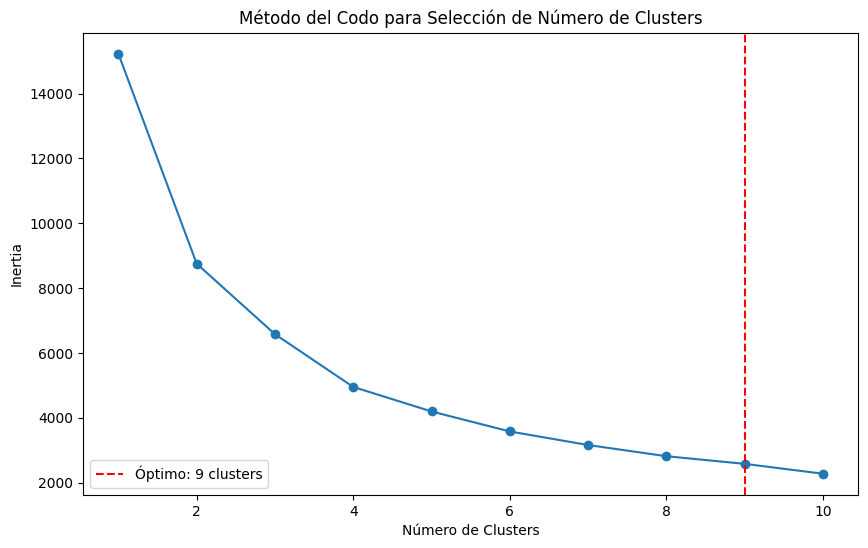

,num_clusters,inertia,silhouette_score,davies_bouldin_score,selected
0,1,15227.177884,0.000000,0.000000,0
1,2,8752.958306,0.367046,1.022717,0
2,3,6578.733080,0.327396,1.024926,0
3,4,4952.271737,0.338855,0.875074,0
4,5,4196.607183,0.319554,0.927017,0
5,6,3579.546850,0.317565,0.914110,0
6,7,3161.642871,0.317366,0.899640,0
7,8,2816.286189,0.312573,0.888946,0
8,9,2580.676837,0.312040,0.900106,1
9,10,2276.349778,0.330977,0.829606,0


In [10]:
# Método del codo
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))
        davies_bouldin_scores.append(davies_bouldin_score(X_pca, kmeans.labels_))
    else:
        silhouette_scores.append(0)
        davies_bouldin_scores.append(0)

# Determinar el número óptimo de clusters usando el método del codo
diff = np.diff(inertia)
diff_r = diff[1:] / diff[:-1]
optimal_k = k_range[np.argmax(diff_r) + 1]
logging.info(f"Número óptimo de clusters seleccionado: {optimal_k}")

# Visualización del método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo para Selección de Número de Clusters')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Óptimo: {optimal_k} clusters')
plt.legend()
plt.show()

# Guardar métricas del codo en la base de datos
elbow_data = pd.DataFrame({
    'num_clusters': k_range,
    'inertia': inertia,
    'silhouette_score': silhouette_scores,
    'davies_bouldin_score': davies_bouldin_scores,
    'selected': [1 if k == optimal_k else 0 for k in k_range]
})

elbow_data

## 5. Entrenamiento del Modelo K-Means

Entrenamos el modelo K-Means con el número óptimo de clusters y evaluamos su calidad.

2025-06-29 17:04:56,521 - INFO - Métricas del modelo: Silhouette Score=0.312, Davies-Bouldin Score=0.900, Mean Squared Distance=1.290, Quality=Aceptable


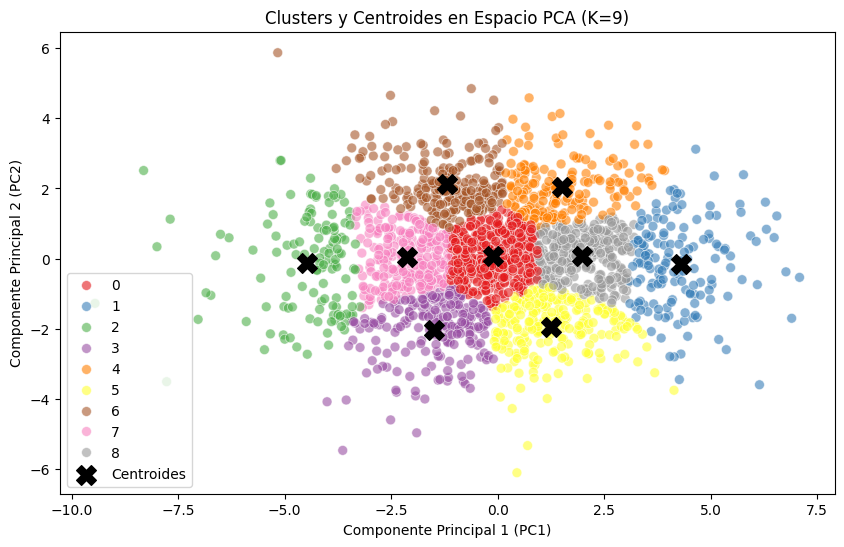

In [ ]:
# Entrenar el modelo K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)

# Asignar etiquetas de cluster a los datos
df['cluster'] = kmeans.labels_

# Calcular métricas del modelo
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
davies_bouldin_avg = davies_bouldin_score(X_pca, kmeans.labels_)
mean_squared_distance = kmeans.inertia_ / len(X_pca)

# Determinar la calidad del modelo
def determine_quality(silhouette, davies_bouldin):
    if silhouette >= 0.5 and davies_bouldin <= 1.0:
        return 'Bueno'
    elif silhouette >= 0.3 and davies_bouldin <= 1.5:
        return 'Aceptable'
    else:
        return 'Pobre'

quality = determine_quality(silhouette_avg, davies_bouldin_avg)

logging.info(f"Métricas del modelo: Silhouette Score={silhouette_avg:.3f}, Davies-Bouldin Score={davies_bouldin_avg:.3f}, Mean Squared Distance={mean_squared_distance:.3f}, Quality={quality}")

# Visualizar clusters y centroides en el espacio de PC1 y PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set1', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroides')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.title(f'Clusters y Centroides en Espacio PCA (K={optimal_k})')
plt.legend()
plt.show()

## 6. Almacenamiento de Resultados

Guardamos las asignaciones de clusters y las métricas del modelo (incluyendo calidad) en SQL Server.

In [77]:
# Guardar asignaciones de clusters
cluster_results = df[['employee_id', 'cluster']]
cursor = conn.cursor()
cursor.execute("TRUNCATE TABLE Employee_Clusters")
for _, row in cluster_results.iterrows():
    # Convertir numpy.int64 a int estándar de Python
    employee_id = int(row['employee_id'])
    cluster = int(row['cluster'])
    cursor.execute(
        "INSERT INTO Employee_Clusters (employee_id, cluster) VALUES (%s, %s)",
        (employee_id, cluster)
    )

# Guardar métricas del modelo
run_datetime = datetime.datetime.now()
cursor.execute(
    "INSERT INTO Clustering_Metrics (run_datetime, num_clusters, silhouette_score, davies_bouldin_score, mean_squared_distance, quality) VALUES (%s, %s, %s, %s, %s, %s)",
    (run_datetime, optimal_k, silhouette_avg, davies_bouldin_avg, mean_squared_distance, quality)
)

conn.commit()
conn.close()
print("Resultados de clustering y métricas guardados en la base de datos.")

Resultados de clustering y métricas guardados en la base de datos.


## 7. Visualización de Resultados

Visualizamos las características promedio por cluster y los clusters con sus centroides en el espacio de PCA.

In [12]:


# Datos y configuración (igual que antes)
cluster_summary = df.groupby('cluster')[
    ['salary', 'age', 'tenure', 'performance_score', 
     'avg_hours_worked', 'avg_overtime_hours', 
     'avg_satisfaction_score', 'turnover_probability']
].mean()

column_settings = {
    'salary': {'cmap': 'vlag', 'direction': -1},
    'age': {'cmap': 'vlag', 'direction': 1},
    'tenure': {'cmap': 'vlag', 'direction': -1},
    'performance_score': {'cmap': 'vlag', 'direction': -1},
    'avg_hours_worked': {'cmap': 'vlag', 'direction': -1},
    'avg_overtime_hours': {'cmap': 'vlag', 'direction': 1},
    'avg_satisfaction_score': {'cmap': 'vlag', 'direction': -1},
    'turnover_probability': {'cmap': 'vlag', 'direction': 1}
}

# Crear figura
fig, axs = plt.subplots(1, len(cluster_summary.columns), 
                       figsize=(24, 12),
                       sharey=True,
                       gridspec_kw={'wspace': 0.05})

# Ocultar ejes redundantes
for ax in axs[1:]:
    ax.yaxis.set_visible(False)

# Heatmaps individuales
for ax, (colname, settings) in zip(axs, column_settings.items()):
    col_data = cluster_summary[[colname]]
    
    # Normalización según dirección
    if settings['direction'] == 1:
        norm_data = (col_data - col_data.min()) / (col_data.max() - col_data.min())
    else:
        norm_data = (col_data.max() - col_data) / (col_data.max() - col_data.min())
    
    sns.heatmap(norm_data,
                annot=col_data.round(2),
                fmt='',
                cmap=settings['cmap'],
                cbar=False,
                ax=ax,
                linewidths=0.5,
                vmin=0,
                vmax=1)
    
    ax.set_title(colname, pad=12)
    ax.set_xlabel('')
    ax.set_xticks([])

# Configuración global
axs[0].set_ylabel('Cluster')
fig.suptitle('Análisis de Clusters por Característica', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# Visualizar clusters y centroides en el espacio de PC1 y PC2
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set1', s=50, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroides')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.title('Clusters y Centroides en Espacio PCA (PC1 y PC2)')
plt.legend()
plt.show()

# Preparar datos para pairplot con PC1 a PC4
# Asegurarse de que X_pca tenga al menos 4 componentes (PCA original calcula todos, tomamos los primeros 4)
X_pca_extended = pca.transform(X_scaled)[:, :4]  # Tomar PC1, PC2, PC3, PC4
pca_df = pd.DataFrame(X_pca_extended, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df['cluster'] = df['cluster']

# Generar pairplot para PC1 a PC4
plt.figure(figsize=(12, 10))
sns.pairplot(pca_df, hue='cluster', palette='Set1', diag_kind='hist', plot_kws={'alpha': 0.6, 's': 50})
plt.suptitle('Pairplot de PC1 a PC4 con Asignación de Clusters', y=1.02)
plt.show()

logging.info("Visualización de perfiles de clusters, gráfico PCA y pairplot generados.")


KeyError: "Columns not found: 'avg_hours_worked', 'turnover_probability', 'avg_overtime_hours', 'performance_score', 'age', 'avg_satisfaction_score', 'tenure', 'salary'"

In [79]:
df.head(10)

,employee_id,first_name,last_name,age,salary,hire_date,termination_date,onleave_date,performance_score,avg_hours_worked,...,job_role_Supervisor,location_Houston,location_Los Angeles,location_Miami,location_New York,shift_type_Morning,shift_type_Night,turnover_risk_level_Moderate,turnover_risk_level_No Risk,cluster
0,1847,Audrey,Williams,35,91976.17,2021-06-10,NaT,None,3,5.850000,...,False,False,True,False,False,False,False,False,True,5
1,1023,Tammy,Rogers,27,70459.79,2017-07-11,NaT,None,3,5.630000,...,False,False,False,False,False,True,False,False,True,5
2,1615,Robert,Johnson,20,40049.55,2024-08-14,NaT,None,8,5.700000,...,False,False,True,False,False,False,False,False,True,0
3,1660,David,Brown,26,63957.78,2016-10-07,NaT,None,10,5.650000,...,False,False,False,True,False,False,True,False,True,0
4,1521,Timothy,Mills,37,70665.66,2022-01-23,2022-09-14,None,2,5.700304,...,False,False,False,True,False,True,False,False,False,2
5,1219,Dawn,Hurley,45,87512.74,2019-01-06,NaT,None,9,5.810000,...,False,False,False,True,False,False,False,False,True,5
6,1481,Thomas,Neal,28,51368.67,2023-12-31,NaT,None,7,5.680000,...,False,False,False,False,True,True,False,False,True,0
7,1535,William,Jackson,29,87985.06,2019-11-07,NaT,2023-08-18,9,5.700304,...,False,False,False,False,True,True,False,False,True,5
8,1585,David,Larsen,31,70800.58,2015-09-11,2019-08-13,None,10,5.700304,...,False,False,False,False,True,True,False,False,True,5
9,1053,Stephen,Summers,23,34273.28,2021-11-15,2025-03-23,None,3,5.770000,...,False,False,False,False,True,False,False,True,False,2
